1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [1]:
# pip install imblearn

In [ ]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.0075, # 0.0075

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=False,
    downsampled_pass_rate=1.0,
    upsampled_fail_rate_about_pass=0.40
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Feature Engineering...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (IsoForest)...


/home/sangho/ML/competition/factory/kamp/preprocess.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,feature] = data.loc[:, feature].fillna(fill_val)


[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89079, 23)
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

======================= [Done] =======================


# CSV 저장

In [3]:
import pandas as pd
df_train = pd.DataFrame()
df_train = pd.DataFrame(x_train)
df_train['passorfail'] = pd.DataFrame(y_train)
df_test = pd.DataFrame()
df_test = pd.DataFrame(x_test)
df_test['passorfail'] = pd.DataFrame(y_test)
df_train.to_csv('train_resample.csv', index=True)
df_test.to_csv('test_resample.csv', index=True)

In [4]:
import pandas as pd
x_train = pd.read_csv('train_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_train =pd.read_csv('train_resample.csv')['passorfail']
x_test = pd.read_csv('test_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_test = pd.read_csv('test_resample.csv')['passorfail']
x_test.head()

,count,working,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,EMS_operation_time,tryshot_signal,mold_code,heating_furnace
0,0.438438,1,0.128866,0.251546,0.700000,0.757732,0.890909,0.075829,0.128151,0.037337,0.561605,0.163165,0.017637,0.304501,0.936228,1,0.0,1,1
1,0.804805,1,0.126289,0.245361,0.733333,0.288660,0.822727,0.132701,0.134454,0.041855,0.464183,0.168768,0.017637,0.315049,0.971506,0,0.0,1,0
2,0.381381,1,0.118557,0.241237,0.733333,0.288660,0.877273,0.132701,0.144258,0.031867,0.335244,0.144258,0.017637,0.121660,0.964722,0,0.0,0,0
3,0.588589,1,0.131443,0.251546,0.733333,0.288660,0.918182,0.104265,0.111345,0.032342,0.724928,0.125350,0.017637,0.321378,0.963365,1,0.0,1,1
4,0.054054,1,0.126289,0.249485,0.726667,0.288660,0.922727,0.116114,0.138655,0.033056,0.604585,0.100840,0.017637,0.388186,0.963365,1,0.0,1,1


# Modeling

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [6]:
def modelTest(model):
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    for train_idx, val_idx in strat_folder.split(x_train, y_train):
        train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(train_data, train_label)

        val_pred = model.predict(val_data)
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]
    model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

    plt.figure(figsize=(15,5))

    # validation
    plt.subplot(1,2,1)
    pred = model.predict(x_train.iloc[best_fold_val_idx])
    cm = confusion_matrix(y_train[best_fold_val_idx], pred)
    sns.heatmap(cm, annot=True, fmt='.0f')

    # test
    plt.subplot(1,2,2)
    pred = model.predict(x_test)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred))
    print(f'test f1_score : {f1_score(y_test, pred)}')

# LGBM

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 78845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916300
[LightGBM] [Info] Start training from score -0.916300
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      0.99      0.99     19712
weighted avg       1.00      1.00      1.00     19712

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[

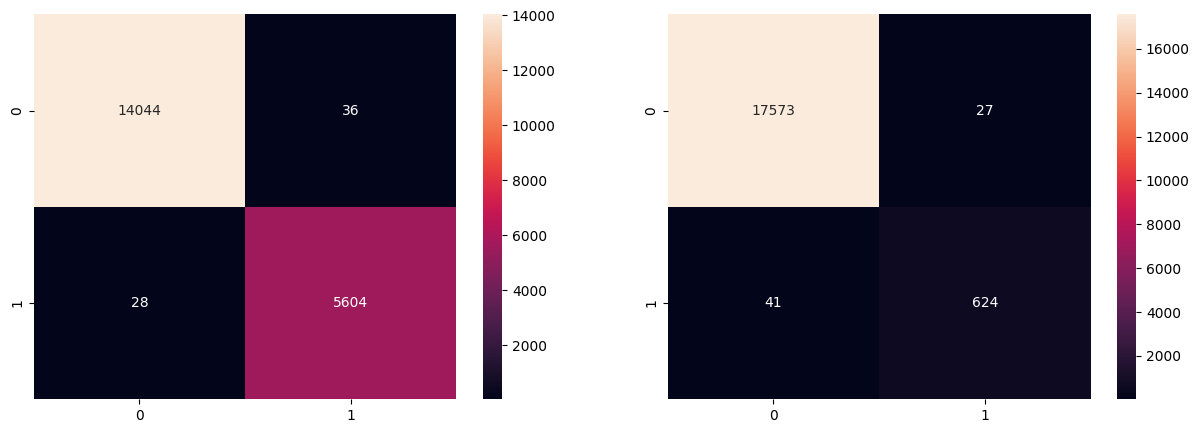

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9483282674772036


In [7]:
model = LGBMClassifier(random_state=42)
modelTest(model)

# XGBoost

StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 2 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 3 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      1.00      0.99      5632

    accuracy                           1.00     19712

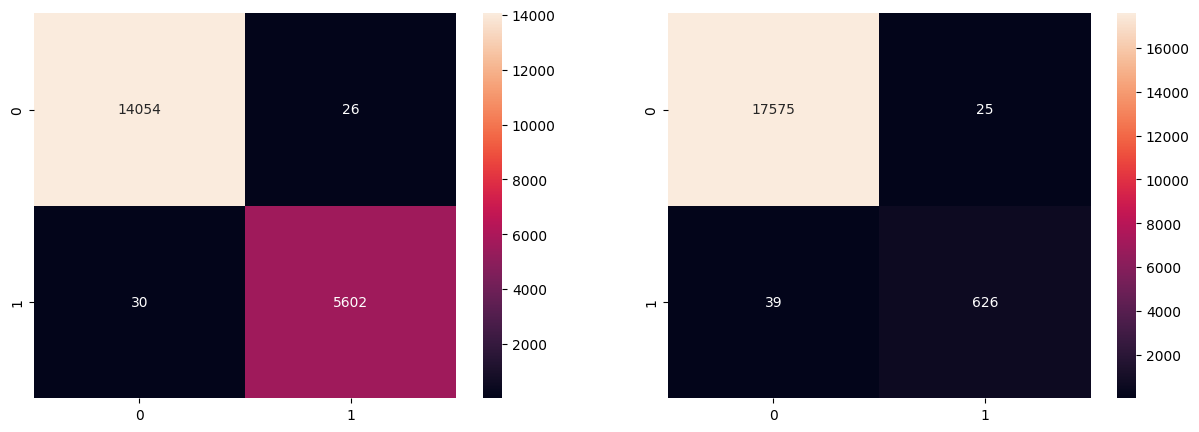

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9513677811550152


In [8]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
modelTest(model)

# Conv1D

In [9]:
# !pip install tensorflow

In [1]:
import pandas as pd
x_train = pd.read_csv('train_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_train =pd.read_csv('train_resample.csv')['passorfail']
x_test = pd.read_csv('test_resample.csv').drop(columns=['passorfail','Unnamed: 0'])
y_test = pd.read_csv('test_resample.csv')['passorfail']

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류의 경우 sigmoid 사용
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model
def build_resnet_1d(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(filters=64, kernel_size=7, padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Residual Blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully Connected Layer for Binary Classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-10-31 20:25:14.502083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 20:25:14.571784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 20:25:15.742730: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-10-31 20:25:15.742813: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-10-31 20:25:15.747159: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류의 경우 sigmoid 사용
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model
def build_resnet_1d(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(filters=64, kernel_size=7, padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Residual Blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully Connected Layer for Binary Classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
# x_train과 x_test의 차원을 CNN에 맞게 변환 (예: (samples, timesteps, features))
x_train_cnn = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

In [4]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def modelTest_CNN():
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    input_shape = (x_train_cnn.shape[1], x_train_cnn.shape[2])  # CNN 모델 입력 크기 정의

    for train_idx, val_idx in strat_folder.split(x_train_cnn, y_train):
        train_data, val_data = x_train_cnn[train_idx], x_train_cnn[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # CNN 모델 생성 및 학습
        model = create_cnn_model(input_shape)
        model.fit(train_data, train_label, epochs=10, batch_size=32, verbose=1)

        val_pred = (model.predict(val_data) > 0.5).astype("int32")  # 이진 분류일 때 예측값을 이진으로 변환
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")
        break # 너무 오래 걸리고 비슷해서 1번만 시행

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

    # 최적의 fold에서 다시 학습 (train set 전체로 학습)
    model.fit(x_train_cnn[best_fold_train_idx], y_train.iloc[best_fold_train_idx], epochs=10)

    plt.figure(figsize=(15,5))

    # validation confusion matrix
    plt.subplot(1,2,1)
    pred_val = (model.predict(x_train_cnn[best_fold_val_idx]) > 0.5).astype("int32")
    cm_val = confusion_matrix(y_train.iloc[best_fold_val_idx], pred_val)
    sns.heatmap(cm_val, annot=True, fmt='.0f')

    # test confusion matrix
    plt.subplot(1,2,2)
    pred_test = (model.predict(x_test_cnn) > 0.5).astype("int32")
    cm_test = confusion_matrix(y_test, pred_test)
    sns.heatmap(cm_test, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred_test))
    print(f'test f1_score : {f1_score(y_test, pred_test)}')

In [5]:
x_train.shape, x_test.shape

((98557, 19), (18265, 19))

Epoch 1/10


2024-10-31 20:25:44.760313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 20:25:44.762902: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (Intel(R) Iris(R) Xe Graphics)
2024-10-31 20:25:44.786651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 20:25:44.786687: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-10-31 20:25:44.786707: I tensorflow/core/common_runtime/pluggable_device/plug

2464/2464 [==============================] - 30s 10ms/step - loss: 0.3782 - accuracy: 0.8538
Epoch 2/10
2464/2464 [==============================] - 23s 10ms/step - loss: 0.2615 - accuracy: 0.9127
Epoch 3/10
2464/2464 [==============================] - 23s 9ms/step - loss: 0.2347 - accuracy: 0.9223
Epoch 4/10
2464/2464 [==============================] - 25s 10ms/step - loss: 0.2249 - accuracy: 0.9250
Epoch 5/10
2464/2464 [==============================] - 24s 10ms/step - loss: 0.2115 - accuracy: 0.9299
Epoch 6/10
2464/2464 [==============================] - 20s 8ms/step - loss: 0.1987 - accuracy: 0.9354
Epoch 7/10
2464/2464 [==============================] - 24s 10ms/step - loss: 0.1755 - accuracy: 0.9445
Epoch 8/10
2464/2464 [==============================] - 19s 8ms/step - loss: 0.1609 - accuracy: 0.9504
Epoch 9/10
2464/2464 [==============================] - 20s 8ms/step - loss: 0.1543 - accuracy: 0.9534
Epoch 10/10
 65/616 [==>...........................] - ETA: 1s

2024-10-31 20:29:36.756220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


616/616 [==============================] - 2s 2ms/step


2024-10-31 20:29:38.230003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 20:29:38.230054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14506 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-10-31 20:29:38.343712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 20:29:38.343783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14506 MB memory) -> physical PluggableDevice (device: 0, name: 

StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14080
         1.0       0.98      0.88      0.93      5632

    accuracy                           0.96     19712
   macro avg       0.96      0.94      0.95     19712
weighted avg       0.96      0.96      0.96     19712

   Fold        F1
0     1  0.925905
Epoch 1/10
2464/2464 [==============================] - 23s 9ms/step - loss: 0.1444 - accuracy: 0.9576
Epoch 2/10
2464/2464 [==============================] - 30s 12ms/step - loss: 0.1427 - accuracy: 0.9580
Epoch 3/10
2464/2464 [==============================] - 24s 10ms/step - loss: 0.1423 - accuracy: 0.9580
Epoch 4/10
2464/2464 [==============================] - 22s 9ms/step - loss: 0.1406 - accuracy: 0.9590
Epoch 5/10
2464/2464 [==============================] - 25s 10ms/step - loss: 0.1388 - accuracy: 0.9594
Epoch 6/10
2464/2464 [==============================] - 25s 10ms/step - loss

2024-10-31 20:33:48.960148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


571/571 [==============================] - 2s 4ms/step


2024-10-31 20:33:51.177896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 20:33:51.177959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14506 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


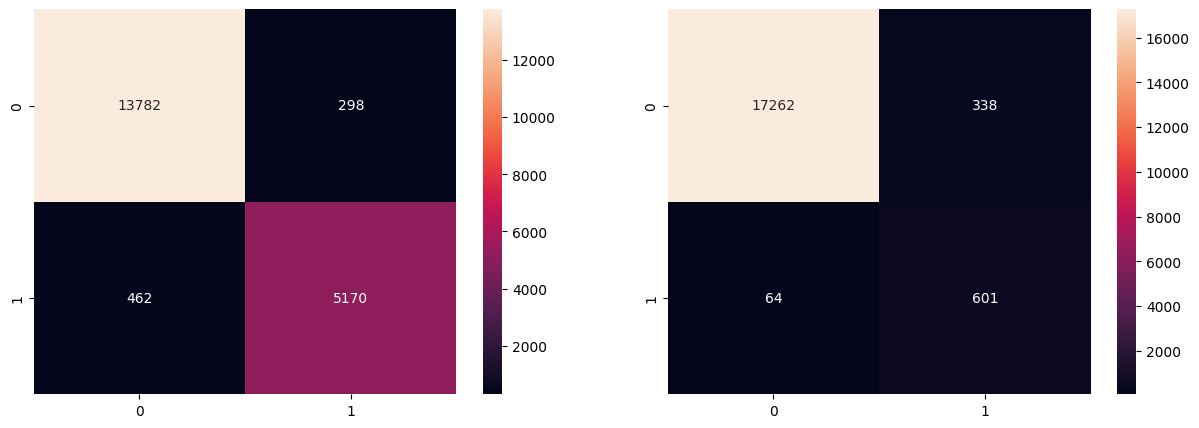

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     17600
         1.0       0.64      0.90      0.75       665

    accuracy                           0.98     18265
   macro avg       0.82      0.94      0.87     18265
weighted avg       0.98      0.98      0.98     18265

test f1_score : 0.7493765586034914


In [8]:
modelTest_CNN()

ResNet 모델

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ResNet 블록 정의 (이전과 동일)
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

# ResNet 모델 정의 (이전과 동일)
def build_resnet_1d(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(filters=64, kernel_size=7, padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Residual Blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully Connected Layer for Binary Classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 입력 데이터의 shape을 맞춰줍니다. (예: (samples, timesteps=19, features=1))
# input_shape = (19, 1)
input_shape = (x_train_cnn.shape[1], x_train_cnn.shape[2])
model = build_resnet_1d(input_shape)

# 데이터 차원 맞추기 (timesteps 추가: 19개의 feature를 가진 데이터를 처리하기 위해 3차원으로 변환)
x_train_reshaped = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

# 모델 학습
model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32)

# Train 데이터에 대한 예측 및 평가
train_pred = (model.predict(x_train_reshaped) > 0.5).astype("int32")
print("Train Data Classification Report:")
print(classification_report(y_train, train_pred))

# Confusion Matrix 시각화 (Train 데이터)
train_cm = confusion_matrix(y_train, train_pred)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)  # 2개의 subplot 중 첫 번째에 그리기
sns.heatmap(train_cm, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Train Set')

# Test 데이터에 대한 예측 및 평가
test_pred = (model.predict(x_test_reshaped) > 0.5).astype("int32")
print("Test Data Classification Report:")
print(classification_report(y_test, test_pred))

# Confusion Matrix 시각화 (Test 데이터)
test_cm = confusion_matrix(y_test, test_pred)
plt.subplot(1,2,2)  # 2개의 subplot 중 두 번째에 그리기
sns.heatmap(test_cm, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Set')

plt.show()

ValueError: Inputs have incompatible shapes. Received shapes (10, 128) and (10, 64)

# 트랜스포머

In [17]:
# !pip install transformers
# pip install torch

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
train_df = pd.read_csv('train_resample.csv')
train_df = train_df.drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('test_resample.csv')
test_df = test_df.drop('Unnamed: 0',axis=1)

# Encode labels (passorfail column)
label_encoder = LabelEncoder()
train_df['passorfail'] = label_encoder.fit_transform(train_df['passorfail'])
test_df['passorfail'] = label_encoder.fit_transform(test_df['passorfail'])

# Convert all values in the DataFrame to strings
train_df = train_df.astype(str)
test_df = test_df.astype(str)

# Split data into features and labels
x_train = train_df.drop(columns=['passorfail'])
y_train = train_df['passorfail']
x_test = test_df.drop(columns=['passorfail'])
y_test = test_df['passorfail']

train_strings = x_train.apply(lambda row: ' '.join(row.astype(str)), axis=1)
train_list = train_strings.tolist()
test_strings = x_train.apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_list = test_strings.tolist()

y_train = list(y_train)
y_test = list(y_test)

In [20]:
len(train_list[0])
train_list[7]

'0.6456456456456456 1 0.1185567010309278 0.2432989690721649 0.7266666666666667 0.2860824742268041 0.9136363636363636 0.0853080568720379 0.1218487394957983 0.0344827586206896 0.5558739255014327 0.0973389355742296 0.0176369547880498 0.3509142053445851 0.9525101763907732 1 1.0 1 1'

In [21]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the training set
train_encodings = tokenizer(train_list, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_list, truncation=True, padding=True, max_length=512)

In [22]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

In [23]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name 'split_torch_state_dict_into_shards' from 'huggingface_hub' (/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/huggingface_hub/__init__.py)

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Convert logits to predicted class labels
preds = torch.argmax(predictions.predictions, axis=-1)

# Print classification report
print(classification_report(y_test, preds.numpy()))